## Analisis ##
En este proyecto queremos analizar cuales suelen ser los sentimientos(positivos o negativos) en las reseñas dejadas por los usuarios.
Cada reseña cuanta con una variedad de datos, que son:

• ID: A unique ID for each row in the dataset

• ProductId: A reference to the product that the review is about

• UserId: A reference to the user who left the review

• HelpfulnessNumerator: The number of readers of the review who indicated that it was "helpful"

• HelpfulnessDenominator: The total number of people who gave an indication of whether or not the review was "helpful"

• Score: The star rating (1-5)


• Time: A Unix timestamp indicating when the review was created

• Summary: The user-written summary of what the review is about

• Text: The user-written review

## Leer y preparar los datos ##

Se lee toda la data del archivo csv que se va a procesar y se deja listo en una variable


In [27]:
import pandas as pd

data = pd.read_csv('../data/Reviews.csv',nrows=5000)

## Parte 1 ##
Para la primera parte, los registros van a ser reclasificados segun a calificacion en estrellas. las reseñas que tengan 4-5 estrellas, seran remplazadas con una calificacion 1 que sera una clasificacion positiva, las reseñas que tengan 1-2 estrellas seran remplazadas con un cero, y las reseñas que esten con una calificacion de 3 estrellas seran eliminadas.

In [28]:
import numpy as np

#modiicar la columna score
data['Score'] = np.where(data['Score'] >= 4, 1, np.where(data['Score'] <= 2, 0, data['Score']))


# Eliminar las filas donde 'Score' sea igual a 3 (si es necesario)
index_to_drop = data[data['Score'] == 3].index

# Crear un nuevo DataFrame sin las filas que cumplen la condición
data_clean = data.drop(index_to_drop)



Se cambian todas las palabras de la columna de texto a minusculas, ademas se eliminan los caracteres especiales


In [29]:
import re

#convertir todos los textos necesarios a minusculas+
data_clean['Text']=data_clean['Text'].str.lower()

# Convertir a minúsculas y eliminar caracteres especiales en las dos columnas
data_clean['Text'] = data_clean['Text'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))


Se realiza la tokenizacion de palabras de la columna texto, y a su vez se eliminan los stop words

In [30]:
import nltk
from nltk.corpus import stopwords  

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


#se agrega una columna con las palabras tokenizadas
data_clean['TextTokens']=data_clean['Text'].apply(lambda x: nltk.word_tokenize(x))

#se eliminan los stopwords de los tokens
data_clean['TextTokens']= data_clean['TextTokens'].apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words])



[nltk_data] Downloading package stopwords to C:\Users\MARTHA ISABEL
[nltk_data]     VILLAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Se eliminan las palabras mas y menos repetidas

In [31]:
from sklearn.feature_extraction.text import CountVectorizer as cv

#convertir los tokens a texto
data_clean['TextClean']=data_clean['TextTokens'].apply(lambda tokens: ' '.join(tokens) )

print(data_clean.iloc[0]['TextTokens'])
vectorizer = cv()

#se genera la matriz de frecuencia
matriz_frecuencia = vectorizer.fit_transform(data_clean['TextClean'])


#Obtener las palabras y sus frecuencias
word_freq = matriz_frecuencia.toarray().sum(axis=0)
vocab = vectorizer.get_feature_names_out()


# Crear un DataFrame para almacenar palabras y frecuencias
word_counts_df = pd.DataFrame({'Palabra': vocab, 'Frecuencia': word_freq})


# Obtener las palabras más y menos repetidas
palabras_mas_repetidas = word_counts_df.nlargest(15, 'Frecuencia')['Palabra'].tolist()
palabras_menos_repetidas = word_counts_df.nsmallest(15, 'Frecuencia')['Palabra'].tolist()


#eliminamos las palabras mas repetidas de los tokens
data_clean['TextTokens']=data_clean['TextTokens'].apply(lambda tokens: [word for word in tokens if word not in palabras_mas_repetidas] )
data_clean['TextTokens']=data_clean['TextTokens'].apply(lambda tokens: [word for word in tokens if word not in palabras_menos_repetidas] )





['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'product', 'better']


Realizamos una nube de palabras para ver como estan los textos positivos y negativos teniendo en cuenta la calificacion de score establecida anterioremente
score = 1 (positivos)
score = 0 (negativo)

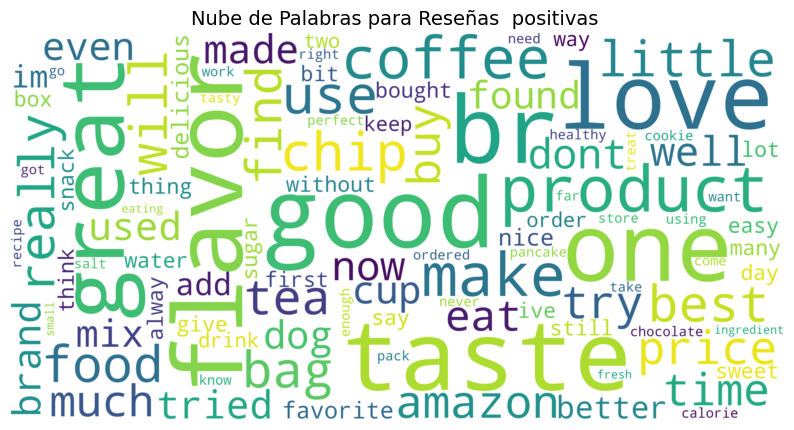

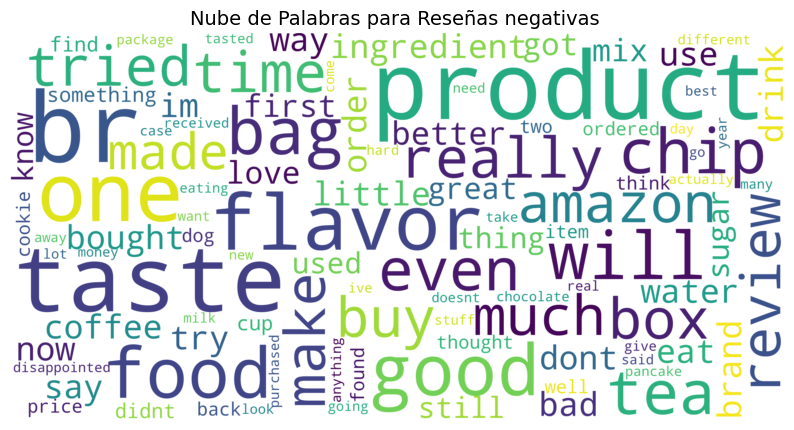

In [32]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

#unimos todos los textos de los comentarios positivos
reviews_pos=data_clean[data_clean['Score']==1]
all_reviews_pos=''.join(reviews_pos['Text'])

#unimos todos los textos de los comentarios negativos
reviews_neg=data_clean[data_clean['Score']==0]
all_reviews_neg=''.join(reviews_neg['Text'])

# Generar la nube de palabras
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", scale=10, width=800, height=400).generate(all_reviews_pos)
    
# Visualizar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f'Nube de Palabras para Reseñas  positivas ', fontsize=14)
plt.show()


# Generar la nube de palabras
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white", scale=10, width=800, height=400).generate(all_reviews_neg)
    
# Visualizar la nube de palabras
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(f'Nube de Palabras para Reseñas negativas ', fontsize=14)
plt.show()



Is removing special characters even a good idea? What are some examples of characters that would likely be safe to remove, and what are some that would not be?

Respond: i think that remove the characters is very ussefull because there are characters that his meaning is not important for the context, some examples of special characters are (!,#,&,@,) this are some examples about the special characters, and the characters that i need, are all letters and numbers

## modelo de regresion logistica ## 

Este es un modelo entregado por la libreria sklearn, el cual esta diseñado para hacer predicciones de datos. este se alimenta con 
muchos tipos de datos bajo cierta clasificacion(en nuestro caso positivo=1 y negativo=0 segun la evaluacion para cada reseña en amazon)
y este aprende de estos datos y termina entregando un porcentaje de acierto 

Como primera parte, creamos una bolsa de palabras con la cual se va a alimentar el modelo

In [33]:
from sklearn.feature_extraction.text import CountVectorizer # se usa para crear la bolsa de palabras
from nltk.tokenize import word_tokenize  # se usa para tokenizar


nltk.download('punkt')  # Para tokenización
nltk.download('stopwords')  # Para las palabras vacías

#stopWrods (aunque anteriormente ya se eliminaron)
noise_words = nltk.corpus.stopwords.words('english')

# Crear el objeto CountVectorizer para generar una amtriz dispersa
vectorizer = CountVectorizer(tokenizer=word_tokenize, stop_words=noise_words, ngram_range=(1, 1))

bow_counts = vectorizer.fit_transform(data_clean['Text'])

[nltk_data] Downloading package punkt to C:\Users\MARTHA ISABEL
[nltk_data]     VILLAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\MARTHA ISABEL
[nltk_data]     VILLAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\MARTHA ISABEL VILLAM\AppData\Local\pypoetry\Cache\virtualenvs\proyecto_de_yelp-j_kxu5WQ-py3.12\Lib\site-packages\sklearn\feature_extraction\text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\MARTHA ISABEL VILLAM\AppData\Local\pypoetry\Cache\virtualenvs\proyecto_de_yelp-j_kxu5WQ-py3.12\Lib\site-packages\sklearn\feature_extraction\text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_

Extraemos los datos de entrenamiento y de prueba y para esto usamos la libreria que ya nos provee no solo el modelo si no la forma de separar los datos para entrenar el modelo. y luego se genera y se entrena el modelo con los datos entregados por la primera funcion

In [34]:
from sklearn.model_selection import train_test_split # funcion para separar los datos para trabajar con el modelo
from sklearn.linear_model import LogisticRegression #modelo de regresion logistica

#Extraemos los review para entrenar, para testear, 
reviews_train,reviews_test,y_train,y_test = train_test_split(bow_counts,data_clean['Score'],test_size=0.2,random_state=0)

#creamos el modelo
model = LogisticRegression(C=1,solver='liblinear')

#entrenamos el modelo
model.fit(reviews_train,y_train)

LogisticRegression(C=1, solver='liblinear')

Hacemos la prediccion con los datos que sacamos para las pruebas y hacemos la evaluacion para ver que tanto acerto nuestro modelo


In [35]:
from sklearn.metrics import accuracy_score,f1_score

#se hace la preddicion
prediccion = model.predict(reviews_test)

#porcentaje de aciertos
accuracy=accuracy_score(y_test,prediccion)

#nivel de presicion
f1 = f1_score(y_test,prediccion)

print(accuracy)#89.9%
print(f1)#94.13%


0.8990228013029316
0.9413249211356467
